In [1]:
import time
t1 = time.time()

import math
import numpy as np
import scipy as sp
import os
import pandas as pd
import uproot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import ripser
import persim

In [2]:
##### setting file path #####

sig_rootpath = "/data/Chen-Wang/gghh_highPT_250/Events/run_01_decayed_1/tag_1_delphes_events.root"
sig_file = uproot.open(sig_rootpath)

ttbarBG_rootpath = "/data/Chen-Wang/ttbarBG/Events/run_01/tag_1_delphes_events.root"
ttbarBG_file = uproot.open(ttbarBG_rootpath)

jjBG_rootpath = "/data/Chen-Wang/jjBG_200PT/Events/run_01/tag_1_delphes_events.root"
jjBG_file = uproot.open(jjBG_rootpath)

In [3]:
##### include signal data #####

sig_events = [sig_file["Delphes;1"]["Particle.Status"].array(),
        sig_file["Delphes;1"]["Particle.PT"].array(),
        sig_file["Delphes;1"]["Particle.Eta"].array(),
        sig_file["Delphes;1"]["Particle.Phi"].array(),
        sig_file["Delphes;1"]["FatJet.Particles"].array(),
        sig_file["Delphes;1"]["FatJet.Eta"].array(),
        sig_file["Delphes;1"]["FatJet.Phi"].array(),
        sig_file["Delphes;1"]["FatJet.PT"].array(),
        sig_file["Delphes;1"]["FatJet"].array(),
        sig_file["Delphes;1"]["FatJet.Mass"].array()
        ]

##### reshape the signal data #####

sig_events = np.expand_dims(sig_events, axis=-1)
sig_events = sig_events.transpose((1,0,2))
sig_events = np.squeeze(sig_events,axis=(2,))

num_sig = len(sig_events)

##### include ttbarBG data #####

ttbarBG_events = [ttbarBG_file["Delphes;1"]["Particle.Status"].array(),
        ttbarBG_file["Delphes;1"]["Particle.PT"].array(),
        ttbarBG_file["Delphes;1"]["Particle.Eta"].array(),
        ttbarBG_file["Delphes;1"]["Particle.Phi"].array(),
        ttbarBG_file["Delphes;1"]["FatJet.Particles"].array(),
        ttbarBG_file["Delphes;1"]["FatJet.Eta"].array(),
        ttbarBG_file["Delphes;1"]["FatJet.Phi"].array(),
        ttbarBG_file["Delphes;1"]["FatJet.PT"].array(),
        ttbarBG_file["Delphes;1"]["FatJet"].array(),
        ttbarBG_file["Delphes;1"]["FatJet.Mass"].array()
        ]

##### reshape the ttbarBG data #####

ttbarBG_events = np.expand_dims(ttbarBG_events, axis=-1)
ttbarBG_events = ttbarBG_events.transpose((1,0,2))
ttbarBG_events = np.squeeze(ttbarBG_events,axis=(2,))

num_ttbarBG = len(ttbarBG_events)

##### include jjBG data #####

jjBG_events = [jjBG_file["Delphes;1"]["Particle.Status"].array(),
        jjBG_file["Delphes;1"]["Particle.PT"].array(),
        jjBG_file["Delphes;1"]["Particle.Eta"].array(),
        jjBG_file["Delphes;1"]["Particle.Phi"].array(),
        jjBG_file["Delphes;1"]["FatJet.Particles"].array(),
        jjBG_file["Delphes;1"]["FatJet.Eta"].array(),
        jjBG_file["Delphes;1"]["FatJet.Phi"].array(),
        jjBG_file["Delphes;1"]["FatJet.PT"].array(),
        jjBG_file["Delphes;1"]["FatJet"].array(),
        jjBG_file["Delphes;1"]["FatJet.Mass"].array()
        ]

##### reshape the jjBG data #####

jjBG_events = np.expand_dims(jjBG_events, axis=-1)
jjBG_events = jjBG_events.transpose((1,0,2))
jjBG_events = np.squeeze(jjBG_events,axis=(2,))

num_jjBG = len(jjBG_events)

t2 = time.time()
print("Time:", t2-t1)

/usr/local/lib/python3.8/dist-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Time: 9.143349885940552


In [4]:
##### useful function #####

##### select if Fat Jet >= 2 #####

def Fat_Jet_selection(events):
    where1 = np.where(events[:,8]>=2)    ### 8: number of fat jet
    return events[where1]

##### select if M_jet > 50 GeV #####

def mass_selection(events):
    where1 = []
    for i in range(len(events)):
        switch=1
        if events[i][9][0]<50:    ### 9: Fat jet mass
            switch=0
        if events[i][9][1]<50:
            switch=0
        if switch==1:
            where1.append(i)
    return events[where1]

##### calculate TDA #####

def TDA(event):
    where_jet_particle = event[4][0]+event[4][1]
    where_jet_particle = np.array(where_jet_particle)-1
#     where_jet_particle = np.where(event[0]==1)[0]
    center_eta = (event[5][0]+event[5][1])/2    ### 5: fat jet eta
    center_phi = (event[6][0]+event[6][1])/2    ### 6: fat jet phi
    particle_eta = event[2][where_jet_particle]-center_eta    ### 2: particle eta, and centerize
    particle_phi = event[3][where_jet_particle]-center_phi    ### 3: particle phi, and centerize

    where_larger_pi = np.where(particle_phi>np.pi)
    particle_phi[where_larger_pi] = -(2*np.pi - particle_phi[where_larger_pi])    ### check if jet particle split
    where_smaller_mpi = np.where(particle_phi<-np.pi)
    particle_phi[where_smaller_mpi] = 2*np.pi + particle_phi[where_smaller_mpi]    ### check if jet particle split
    P = np.array([particle_eta, particle_phi]).T
    diagrams = ripser.ripser(P)['dgms']
    return diagrams

##### calculate TDA sum #####

def TDA_sum(diagrams):
    sum_H0 = np.sum(diagrams[0][:-1,1] - diagrams[0][:-1,0])
    sum_H1 = np.sum(diagrams[1][:,1] - diagrams[1][:,0])
    return sum_H0, sum_H1

##### calculate TDA entropy #####

def TDA_entropy(diagrams):
    z0 = diagrams[0][:-1,1]-diagrams[0][:-1,0]
    S0 = z0*np.log(z0)
    z1 = diagrams[1][:,1]-diagrams[1][:,0]
    S1 = z1*np.log(z1)
    return -np.sum(S0), -np.sum(S1)

##### calculate TDA Lifetime*Birthtime #####

def TDA_LB(diagrams):
    return np.sum(diagrams[1][:,0]*(diagrams[1][:,1]-diagrams[1][:,0]))

In [5]:
##### Selection before put into model #####

print("There are totally", num_sig, "signal events.")
sig_events = Fat_Jet_selection(sig_events)
num_sig = len(sig_events)
print("There are", num_sig, "signal events after 2 fat jet selection.")
sig_events = mass_selection(sig_events)
num_sig = len(sig_events)
print("There are", num_sig, "signal events after fat jet mass selection.")

print("\nThere are totally", num_ttbarBG, "ttbarBG events.")
ttbarBG_events = Fat_Jet_selection(ttbarBG_events)
num_ttbarBG = len(ttbarBG_events)
print("There are", num_ttbarBG, "ttbarBG events after 2 fat jet selection.")
ttbarBG_events = mass_selection(ttbarBG_events)
num_ttbarBG = len(ttbarBG_events)
print("There are", num_ttbarBG, "ttbarBG events after fat jet mass selection.")

print("\nThere are totally", num_jjBG, "jjBG events.")
jjBG_events = Fat_Jet_selection(jjBG_events)
num_jjBG = len(jjBG_events)
print("There are", num_jjBG, "jjBG events after 2 fat jet selection.")
jjBG_events = mass_selection(jjBG_events)
num_jjBG = len(jjBG_events)
print("There are", num_jjBG, "jjBG events after fat jet mass selection.")

There are totally 10000 signal events.
There are 8670 signal events after 2 fat jet selection.
There are 6946 signal events after fat jet mass selection.

There are totally 10000 ttbarBG events.
There are 6160 ttbarBG events after 2 fat jet selection.
There are 5479 ttbarBG events after fat jet mass selection.

There are totally 10000 jjBG events.
There are 6172 jjBG events after 2 fat jet selection.
There are 2711 jjBG events after fat jet mass selection.


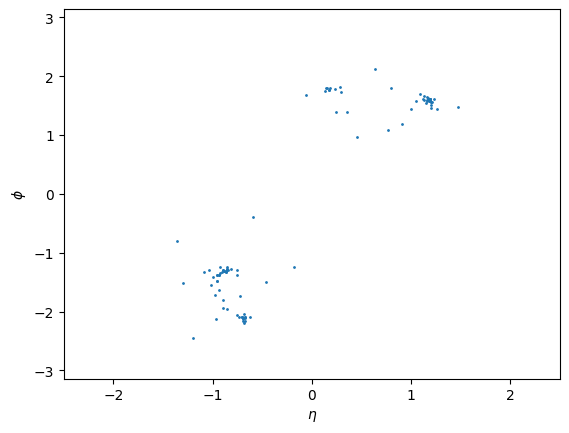

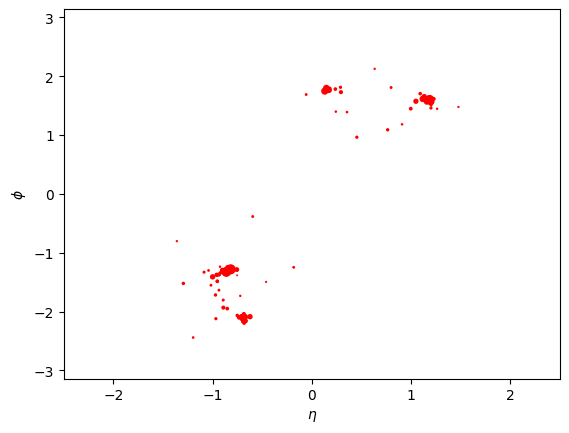

In [6]:
##### plot jet particle scatter #####

event_num = 0
event = sig_events[event_num]

where_jet_particle = event[4][0]+event[4][1]
where_jet_particle = np.array(where_jet_particle)-1
# where_jet_particle = np.where(event[0]==1)[0]

center_eta = (event[5][0]+event[5][1])/2    ### 5: fat jet eta
center_phi = (event[6][0]+event[6][1])/2    ### 6: fat jet phi
particle_eta = event[2][where_jet_particle]-center_eta    ### 2: particle eta, and centerize
particle_phi = event[3][where_jet_particle]-center_phi    ### 3: particle phi, and centerize

where_larger_pi = np.where(particle_phi>np.pi)
particle_phi[where_larger_pi] = -(2*np.pi - particle_phi[where_larger_pi])    ### check if jet particle split
where_smaller_mpi = np.where(particle_phi<-np.pi)
particle_phi[where_smaller_mpi] = 2*np.pi + particle_phi[where_smaller_mpi]    ### check if jet particle split

particle_PT = event[1][where_jet_particle]

plt.scatter(particle_eta, particle_phi, s=1)
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")
plt.xlim(-2.5, 2.5)
plt.ylim(-np.pi, np.pi)
plt.show()

plt.scatter(particle_eta, particle_phi, s=particle_PT, color='r')
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")
plt.xlim(-2.5, 2.5)
plt.ylim(-np.pi, np.pi)
plt.show()

In [7]:
##### calculate TDA #####

P = np.array([particle_eta, particle_phi]).T
print("data shape", np.shape(P))

diagrams = ripser.ripser(P)['dgms']


data shape (104, 2)


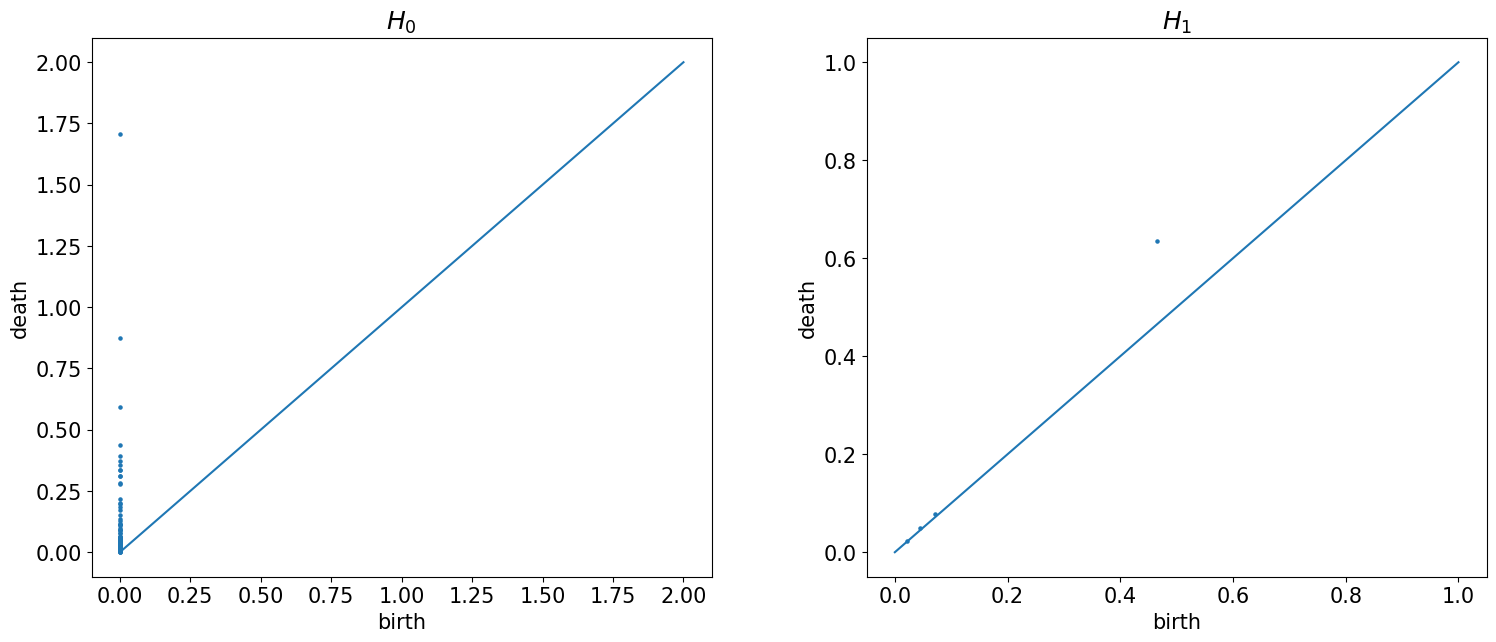

In [8]:
plt.figure(1, figsize=(18,7))
plt.subplots_adjust(wspace=0.25)

ax1 = plt.subplot(121)
ax1.scatter(diagrams[0][:,0], diagrams[0][:,1], s=5)
ax1.plot([0,2], [0,2])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("birth", fontsize=15)
plt.ylabel("death", fontsize=15)
plt.title(r"$H_0$", fontsize=18)

ax2 = plt.subplot(122)
ax2.scatter(diagrams[1][:,0], diagrams[1][:,1], s=5)
ax2.plot([0,1], [0,1])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("birth", fontsize=15)
plt.ylabel("death", fontsize=15)
plt.title(r"$H_1$", fontsize=18)

plt.show()

In [9]:
H_0_sig = []
H_1_sig = []
for i in range(len(sig_events)):
    TDA_tmp = TDA(sig_events[i])
    H_0_sig.append(TDA_sum(TDA_tmp)[0])
    H_1_sig.append(TDA_sum(TDA_tmp)[1])
    
H_0_ttbarBG = []
H_1_ttbarBG = []
for i in range(len(ttbarBG_events)):
    TDA_tmp = TDA(ttbarBG_events[i])
    H_0_ttbarBG.append(TDA_sum(TDA_tmp)[0])
    H_1_ttbarBG.append(TDA_sum(TDA_tmp)[1])
    
H_0_jjBG = []
H_1_jjBG = []
for i in range(len(jjBG_events)):
    TDA_tmp = TDA(jjBG_events[i])
    H_0_jjBG.append(TDA_sum(TDA_tmp)[0])
    H_1_jjBG.append(TDA_sum(TDA_tmp)[1])
    
print("time:", time.time()-t1)

time: 79.09418272972107


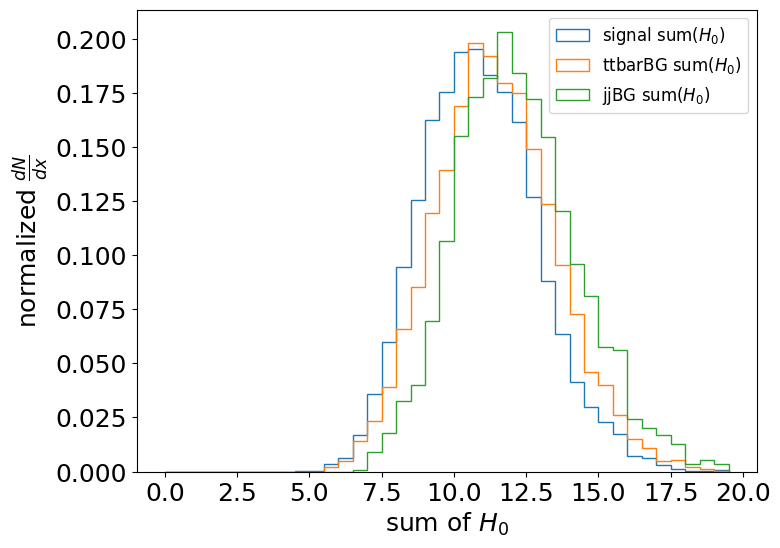

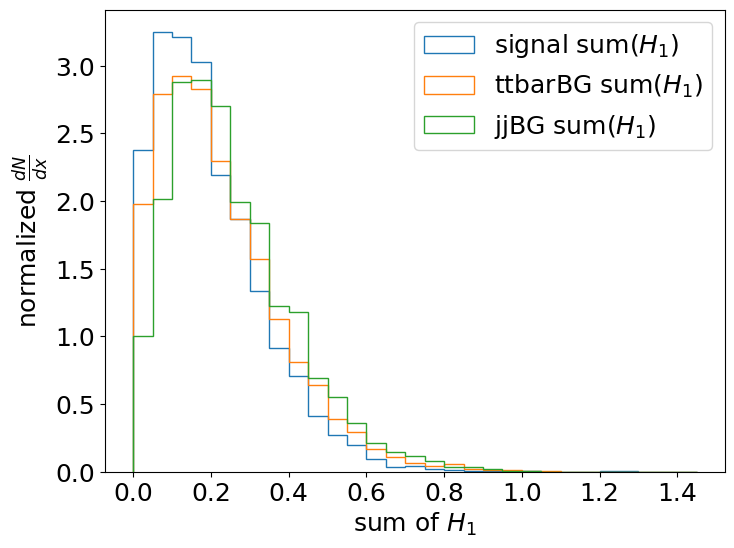

In [10]:
##### plot signal TDA sum #####

plt.figure(1, figsize=(8,6))
bins = np.arange(0,20,0.5)
plt.hist(H_0_sig, bins=bins, label=r"signal sum($H_0$)", histtype='step', density=True)
plt.hist(H_0_ttbarBG, bins=bins, label=r"ttbarBG sum($H_0$)", histtype='step', density=True)
plt.hist(H_0_jjBG, bins=bins, label=r"jjBG sum($H_0$)", histtype='step', density=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"sum of $H_0$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.show()

plt.figure(1, figsize=(8,6))
bins = np.arange(0,1.5,0.05)
plt.hist(H_1_sig, bins=bins, label=r"signal sum($H_1$)", histtype='step', density=True)
plt.hist(H_1_ttbarBG, bins=bins, label=r"ttbarBG sum($H_1$)", histtype='step', density=True)
plt.hist(H_1_jjBG, bins=bins, label=r"jjBG sum($H_1$)", histtype='step', density=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"sum of $H_1$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()

In [11]:
SS_0_sig = []
SS_1_sig = []
for i in range(len(sig_events)):
    TDA_tmp = TDA(sig_events[i])
    SS_0_sig.append(TDA_entropy(TDA_tmp)[0])
    SS_1_sig.append(TDA_entropy(TDA_tmp)[1])
    
SS_0_ttbarBG = []
SS_1_ttbarBG = []
for i in range(len(ttbarBG_events)):
    TDA_tmp = TDA(ttbarBG_events[i])
    SS_0_ttbarBG.append(TDA_entropy(TDA_tmp)[0])
    SS_1_ttbarBG.append(TDA_entropy(TDA_tmp)[1])
    
SS_0_jjBG = []
SS_1_jjBG = []
for i in range(len(jjBG_events)):
    TDA_tmp = TDA(jjBG_events[i])
    SS_0_jjBG.append(TDA_entropy(TDA_tmp)[0])
    SS_1_jjBG.append(TDA_entropy(TDA_tmp)[1])
    
print("time:", time.time()-t1)

time: 148.73112511634827


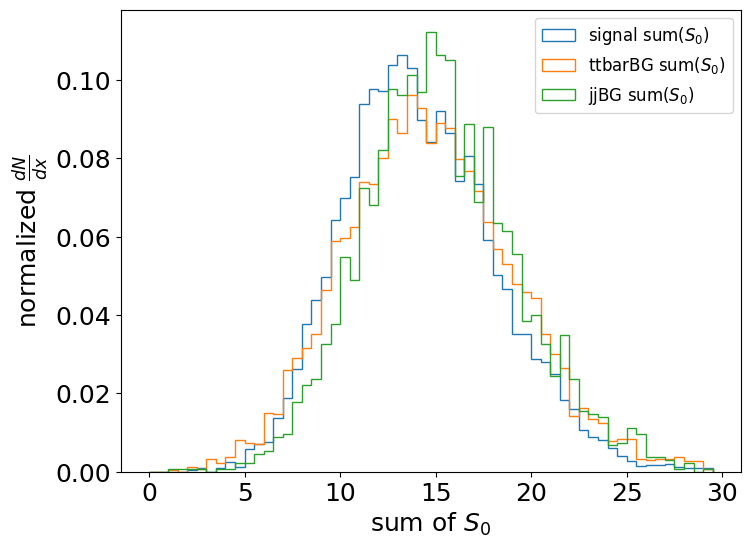

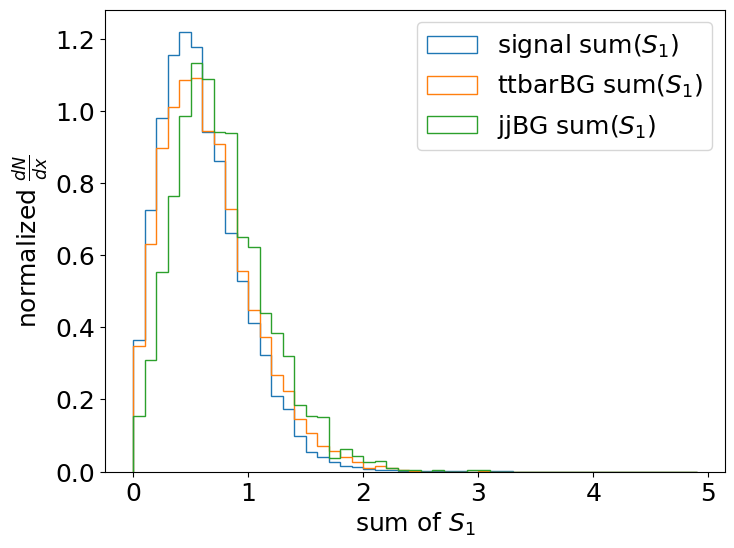

In [12]:
##### plot signal TDA entropy #####

plt.figure(1, figsize=(8,6))
bins = np.arange(0,30,0.5)
plt.hist(SS_0_sig, bins=bins, label=r"signal sum($S_0$)", histtype='step', density=True)
plt.hist(SS_0_ttbarBG, bins=bins, label=r"ttbarBG sum($S_0$)", histtype='step', density=True)
plt.hist(SS_0_jjBG, bins=bins, label=r"jjBG sum($S_0$)", histtype='step', density=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"sum of $S_0$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.show()

plt.figure(1, figsize=(8,6))
bins = np.arange(0,5,0.1)
plt.hist(SS_1_sig, bins=bins, label=r"signal sum($S_1$)", histtype='step', density=True)
plt.hist(SS_1_ttbarBG, bins=bins, label=r"ttbarBG sum($S_1$)", histtype='step', density=True)
plt.hist(SS_1_jjBG, bins=bins, label=r"jjBG sum($S_1$)", histtype='step', density=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"sum of $S_1$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()

In [13]:
LB_1_sig = []
for i in range(len(sig_events)):
    TDA_tmp = TDA(sig_events[i])
    LB_1_sig.append(TDA_LB(TDA_tmp))
    
LB_1_ttbarBG = []
for i in range(len(ttbarBG_events)):
    TDA_tmp = TDA(ttbarBG_events[i])
    LB_1_ttbarBG.append(TDA_LB(TDA_tmp))
    
LB_1_jjBG = []
for i in range(len(jjBG_events)):
    TDA_tmp = TDA(jjBG_events[i])
    LB_1_jjBG.append(TDA_LB(TDA_tmp))
    
print("time:", time.time()-t1)

time: 218.08968138694763


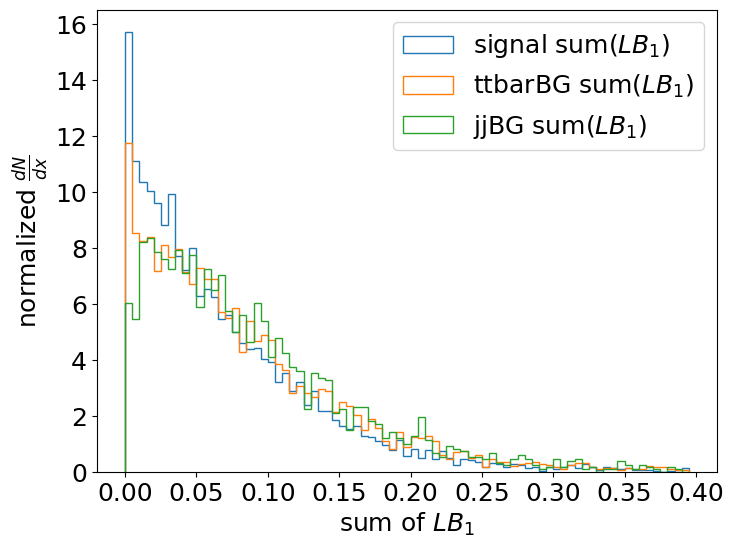

In [14]:
##### plot signal TDA entropy #####

plt.figure(1, figsize=(8,6))
bins = np.arange(0,0.4,0.005)
plt.hist(LB_1_sig, bins=bins, label=r"signal sum($LB_1$)", histtype='step', density=True)
plt.hist(LB_1_ttbarBG, bins=bins, label=r"ttbarBG sum($LB_1$)", histtype='step', density=True)
plt.hist(LB_1_jjBG, bins=bins, label=r"jjBG sum($LB_1$)", histtype='step', density=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"sum of $LB_1$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()